# Access GPM IMERG data on glade 

More information on GPM IMERG: https://gpm.nasa.gov/data/imerg

In [74]:
from pathlib import Path 
import h5py

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

### Read in files for a specific year and month 

In [5]:
# choose year and month 
year = 2020 
month = 6 

gpm_path = Path(str("/glade/campaign/mmm/c3we/prein/observations/GPM_IMERG_V07/"+ str(year) + "/"))

gpm_file_list = list(
    gpm_path.glob(str("3B*IMERG*" + str(year) + str(month).zfill(2) + "*"))
)
gpm_file_list.sort()
print(len(gpm_file_list), "files for GPM found", flush=True)

1440 files for GPM found


### Open file 

In [22]:
fname = gpm_file_list[0]
print(fname)

/glade/campaign/mmm/c3we/prein/observations/GPM_IMERG_V07/2020/3B-HHR.MS.MRG.3IMERG.20200601-S000000-E002959.0000.V07B.HDF5


In [75]:
with h5py.File(fname, "r") as f:
    lat_coords = f["Grid/lat"][:]
    lon_coords = f["Grid/lon"][:]
    precip = f["Grid/precipitation"][:].squeeze()

In [98]:
# make the data an xarray 
coords = {"lat": lat_coords, "lon": lon_coords}
xarray_data = xr.DataArray(
   precip, coords=coords, dims=["lon", "lat"]
)
xarray_data

<xarray.DataArray (lon: 3600, lat: 1800)>
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)
Coordinates:
  * lat      (lat) float32 -89.95 -89.85 -89.75 -89.65 ... 89.75 89.85 89.95
  * lon      (lon) float32 -179.9 -179.9 -179.8 -179.6 ... 179.8 179.8 179.9

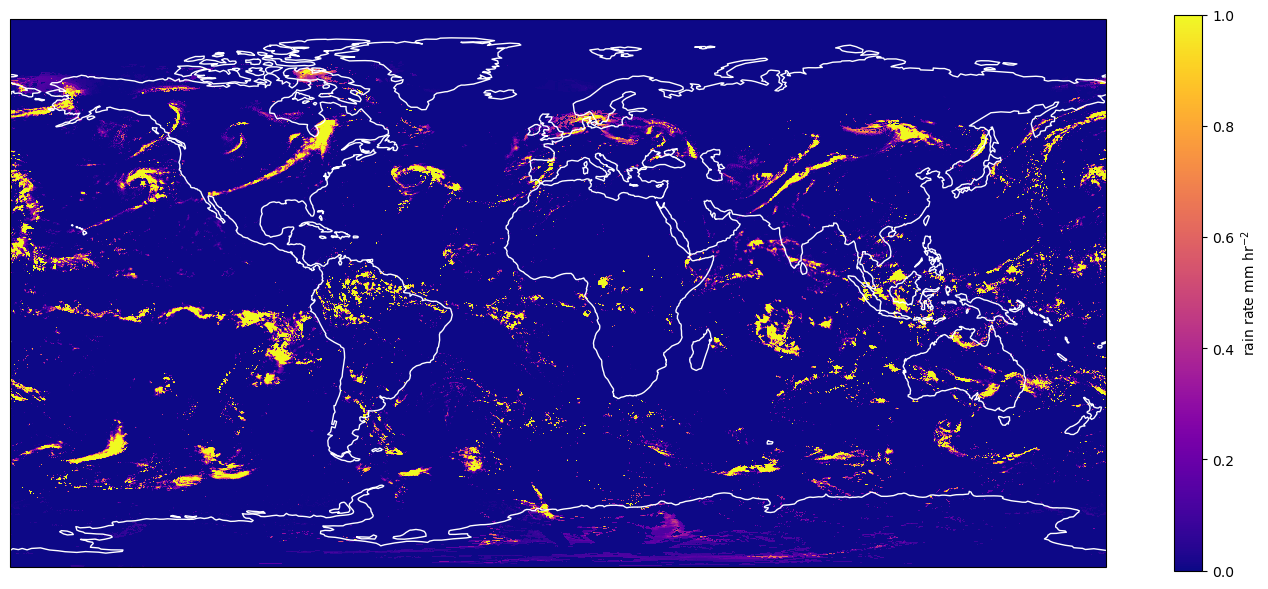

In [92]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np

plt.figure(figsize=(14, 6))

# Set up the map projection
ax = plt.axes(projection=ccrs.PlateCarree())

# Plot with coordinate reference system specified
p = ax.pcolormesh(
    lon_coords, np.flip(lat_coords, axis = 0), precip.T,
    vmin=0, vmax=1, cmap='plasma',
    transform=ccrs.PlateCarree()  # Tell Cartopy what coords your data is in
)

# Add coastlines and other features
ax.coastlines(color = 'white')

# Colorbar
plt.colorbar(p, ax=ax, label='rain rate mm hr$^{-2}$')
plt.tight_layout()
plt.show()


### Regrid data to CONUS404 

In [99]:
def crop_gpm_to_conus(xarray_data, lons, lats):
    """
    Crop GPM IMERG to CONUS extent 

    """
    import numpy as np
    conus_lon_min = -134.02492
    conus_lon_max = -59.963787
    conus_lat_min = 19.80349
    conus_lat_max = 57.837646

    col_start = np.where(lons > conus_lon_min)[0][0]
    col_end = np.where(lons < conus_lon_max)[0][-1]

    row_start = np.where(lats  > conus_lat_min)[0][0]
    row_end = np.where(lats  < conus_lat_max)[0][-1]

    cropped_gpm = xarray_data[{'lat': slice(row_start, row_end), 'lon': slice(col_start, col_end)}]
    return cropped_gpm

In [100]:
def regrid_to_conus(da, latname, lonname): 
    '''                                                                                            
    Regrids GPM IMERG to CONUS404 grid. 

    da: xr.DataArray to be regridded 
    latname: latitude name 
    lonname: longitude name 

    ''' 
    from scipy.interpolate import griddata
    import numpy as np

    input_lons, input_lats = np.meshgrid(da[lonname].compute().data, da[latname].compute().data)

    # values to regrid as flat array 
    values = da.compute().data.flatten()
    points = np.array([ input_lons.flatten(), input_lats.flatten()]).T

    # target grid: CONUS404 
    conus_data = xr.open_dataset(Path('/glade/campaign/mmm/c3we/CPTP_kukulies/conus404/processed/conus404_201010.nc'))
    target_lons = conus_data.lons.values
    target_lats = conus_data.lats.values
    
    regridded = griddata(points, values, (target_lons, target_lats), method = 'nearest') 
    return regridded 

In [101]:
cropped_gpm = crop_gpm_to_conus(xarray_data, lon_coords, lat_coords)

In [118]:
regridded_precip = regrid_to_conus(cropped_gpm.T ,'lat', 'lon')

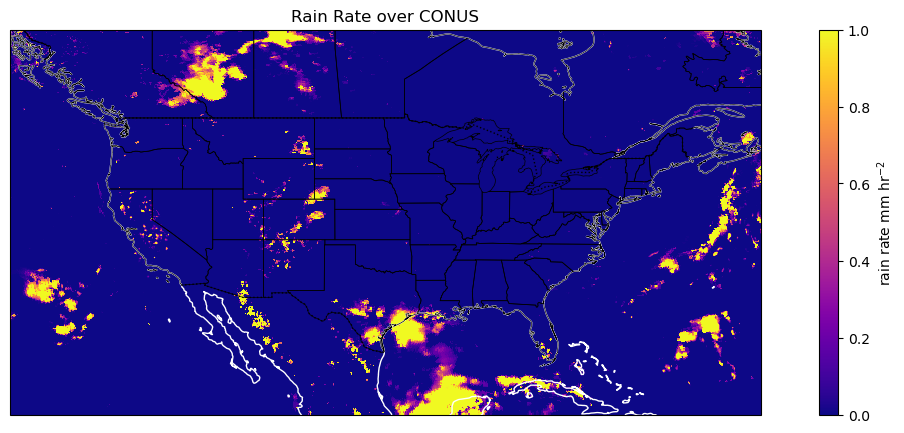

In [105]:
# quick check of the cropped data 

plt.figure(figsize=(15, 5))

ax = plt.axes(projection=ccrs.PlateCarree())

# Plot with coordinate reference system specified
p = ax.pcolormesh(
    cropped_gpm.lon, cropped_gpm.lat, cropped_gpm.T,
    vmin=0, vmax=1, cmap='plasma',
    transform=ccrs.PlateCarree()  
)

# Add coastlines and other features
ax.coastlines(color = 'white')
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.STATES, linewidth=0.5)

# Colorbar
plt.colorbar(p, ax=ax, label='rain rate mm hr$^{-2}$')
plt.title('Rain Rate over CONUS')

plt.show()

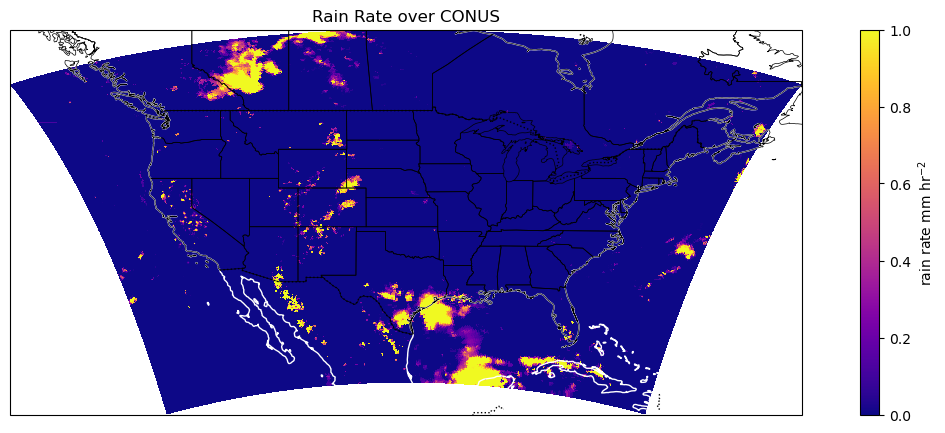

In [120]:
# quick check of the regridded data 

conus_data = xr.open_dataset(Path('/glade/campaign/mmm/c3we/CPTP_kukulies/conus404/processed/conus404_201010.nc'))
target_lons = conus_data.lons.values
target_lats = conus_data.lats.values

plt.figure(figsize=(15, 5))

ax = plt.axes(projection=ccrs.PlateCarree())

# Plot with coordinate reference system specified
p = ax.pcolormesh(
    target_lons, target_lats, regridded_precip,
    vmin=0, vmax=1, cmap='plasma',
    transform=ccrs.PlateCarree()  
)

# Add coastlines and other features
ax.coastlines(color = 'white')
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.STATES, linewidth=0.5)

# Colorbar
plt.colorbar(p, ax=ax, label='rain rate mm hr$^{-2}$')
plt.title('Rain Rate over CONUS')

plt.show()